In [1]:
import numpy as np

from commstools import Signal
from commstools.impairments import apply_awgn, apply_pmd


2026-02-24 13:25:05 [INFO] [commstools/backend.py] CuPy is available and functional, defaulting Signals to GPU.


In [2]:
NUM_SYMBOLS = 2**20
SYMBOL_RATE = 1e9
SPS = 2
MOD = "QAM"
ORDER = 64
ESN0_DB = 25
DGD_SYMBOLS = 0
THETA = np.pi / 4


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


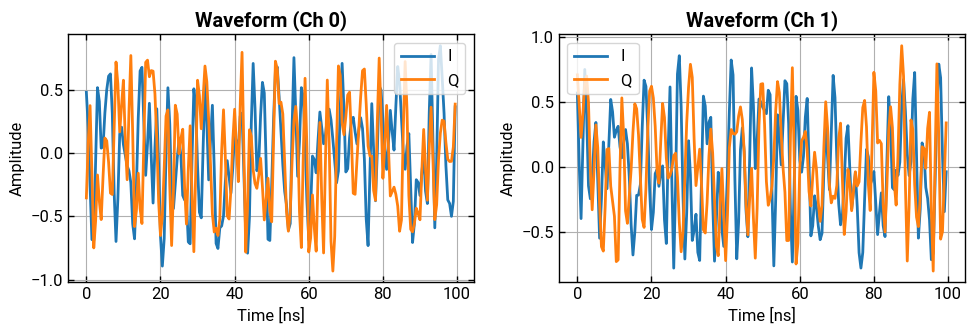

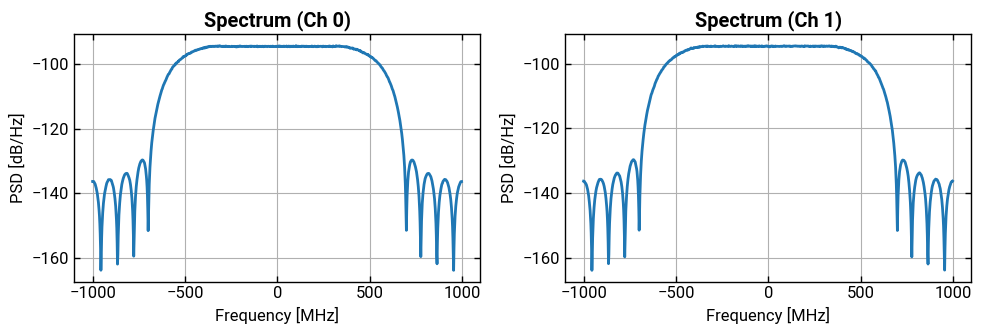

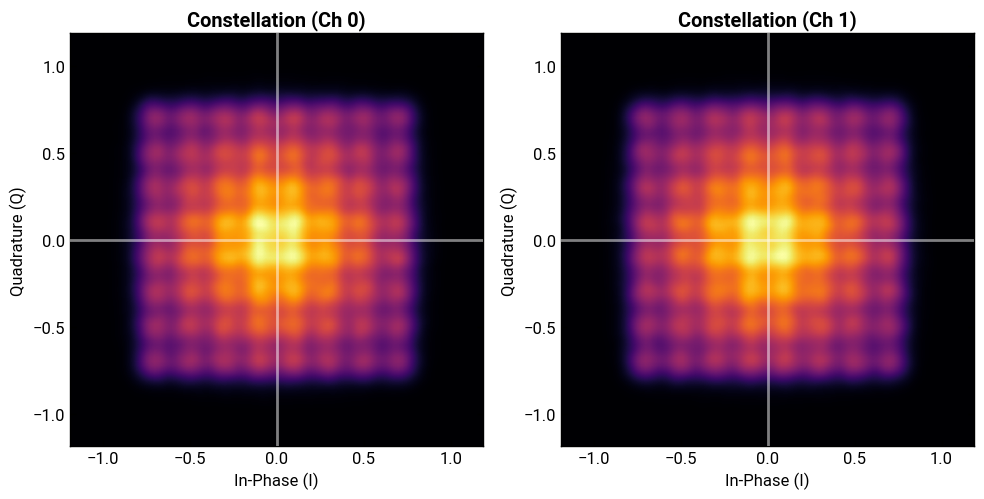

In [3]:
sig = Signal.qam(
    num_symbols=NUM_SYMBOLS,
    sps=SPS,
    symbol_rate=SYMBOL_RATE,
    order=ORDER,
    num_streams=2,
    seed=42,
)
sig.print_info()
sig.plot_waveform(num_symbols=100, show=True)
sig.plot_psd(show=True, nperseg=2**10)
sig.plot_constellation(show=True)


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


2026-02-24 13:25:08 [INFO] [commstools/impairments.py] Adding AWGN (Es/N0 target: 25.00 dB).


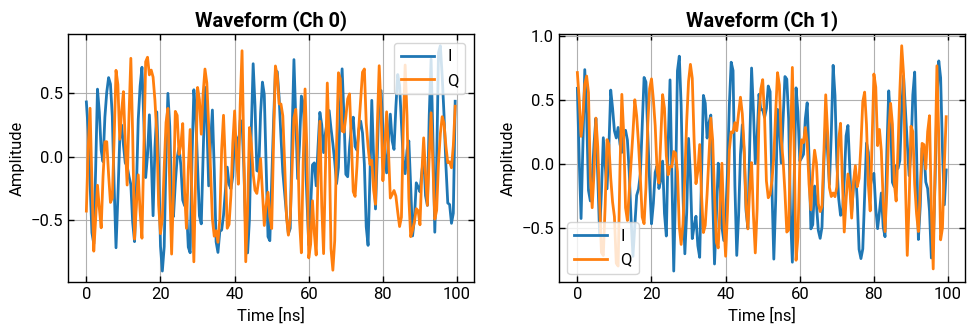

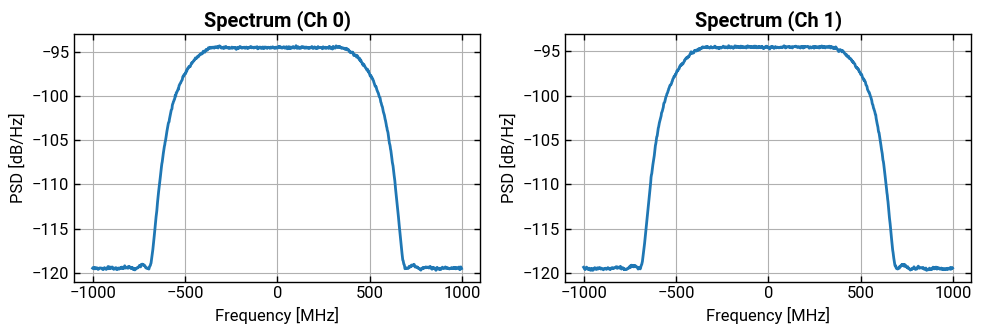

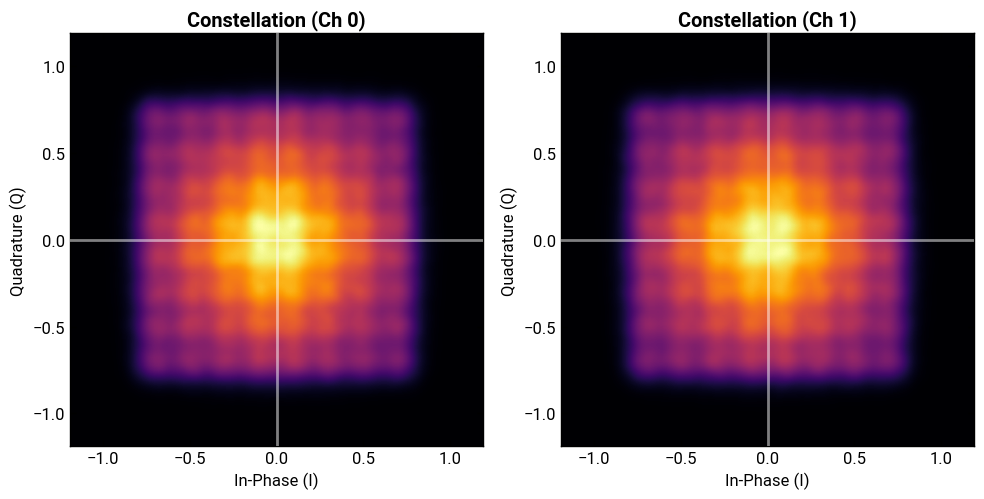

In [4]:
sig_dist = sig.copy()

sig_dist.print_info()
sig_dist = apply_awgn(sig_dist, esn0_db=ESN0_DB)
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-24 13:25:09 [INFO] [commstools/impairments.py] Applying PMD (DGD=0.00e+00 s, theta=0.785 rad).


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


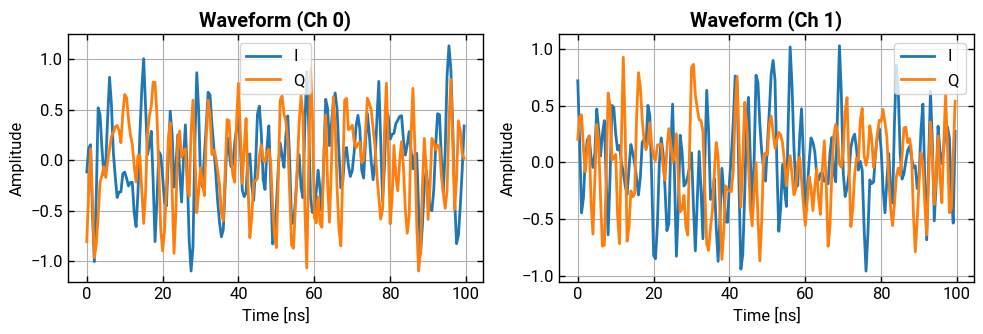

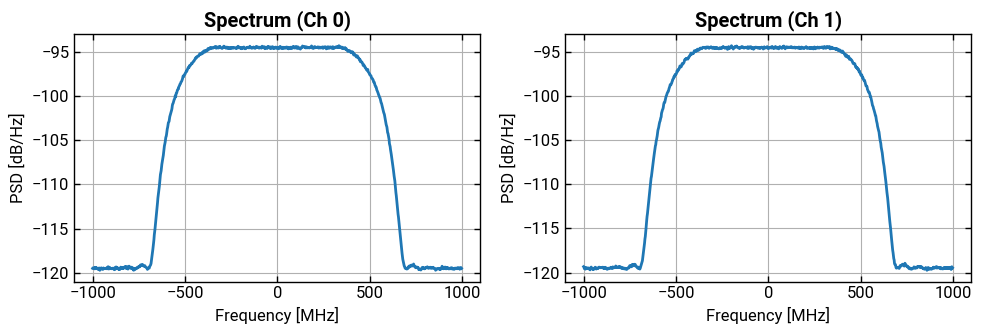

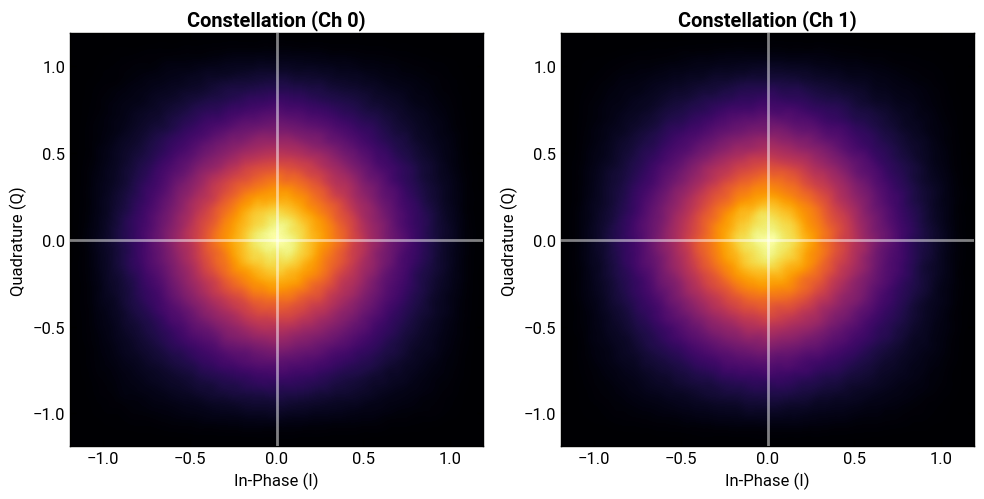

In [5]:
sig_dist = apply_pmd(sig_dist, dgd=DGD_SYMBOLS / SYMBOL_RATE, theta=THETA)

sig_dist.print_info()
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-24 13:25:10 [INFO] [commstools/core.py] Generating shaping filter taps (shape: rrc).


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


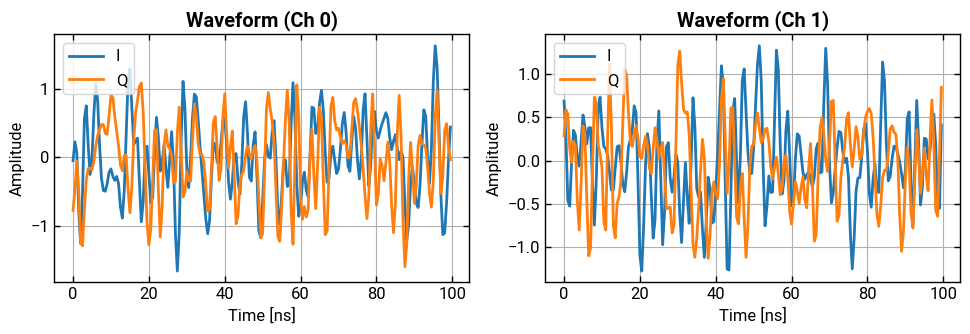

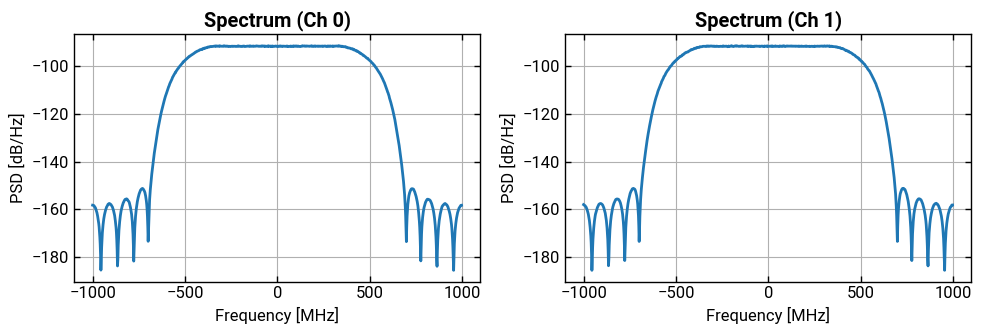

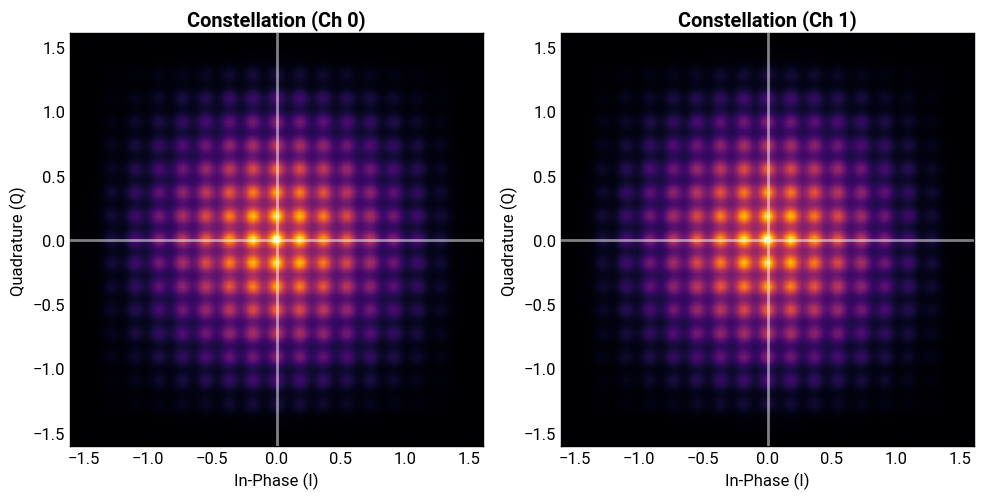

In [6]:
sig_dist.matched_filter()

sig_dist.print_info()
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-24 13:26:57 [INFO] [commstools/equalizers.py] LMS equalizer: num_taps=31, mu=0.1, sps=2, backend=jax, num_train_symbols=1024


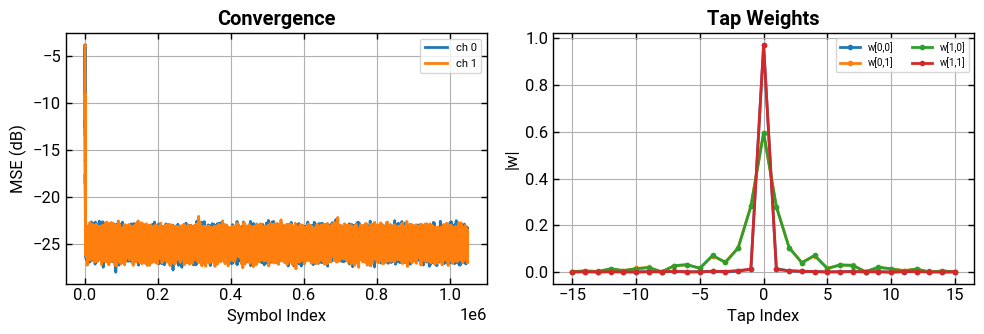

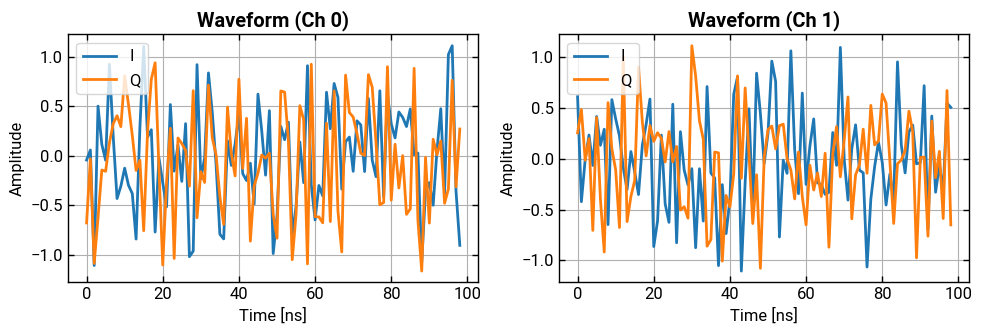

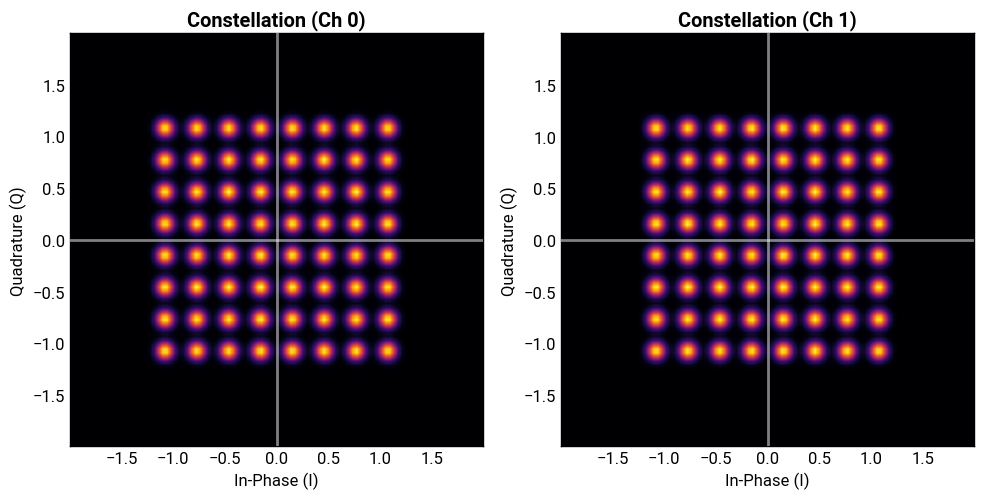

2026-02-24 13:27:00 [INFO] [commstools/core.py] Signal already at 1 sps, no downsampling needed.
2026-02-24 13:27:00 [INFO] [commstools/core.py] Discarding 1024 training symbols for EVM calculation.
2026-02-24 13:27:00 [INFO] [commstools/metrics.py] EVM Ch0: 5.78% (-24.77 dB)
2026-02-24 13:27:00 [INFO] [commstools/metrics.py] EVM Ch1: 5.77% (-24.78 dB)


(array([5.775441 , 5.7703137], dtype=float32),
 array([-24.768297, -24.776012], dtype=float32))

In [19]:
sig_to_eq = sig_dist.copy()

sig_to_eq.equalize(
    method="lms",
    step_size=0.1,
    num_train_symbols=2**10,
    # forgetting_factor=1.0,
    # delta=1.0,
    # leakage=0.0,
    num_taps=31,
    backend="jax",
)
sig_to_eq.plot_equalizer(show=True)

sig_to_eq.plot_waveform(num_symbols=99, show=True)
sig_to_eq.plot_constellation(show=True)
sig_to_eq.resolve_symbols()
sig_to_eq.evm()


In [8]:
sig_to_eq.demap_symbols_hard()
sig_to_eq.ber()


2026-02-24 13:25:30 [INFO] [commstools/core.py] Discarding 1024 training symbols for BER calculation.
2026-02-24 13:25:30 [INFO] [commstools/metrics.py] BER Ch0: 3.28e-05 (204/6224960 errors)
2026-02-24 13:25:30 [INFO] [commstools/metrics.py] BER Ch1: 3.13e-05 (195/6224960 errors)


array([3.27712949e-05, 3.13255025e-05])

In [9]:
sig_to_eq.source_symbols


array([[ 0.77184427-0.46310657j, -0.46310657+0.46310657j,
        -1.0805819 -1.0805819j , ...,  0.77184427-0.46310657j,
         0.15436886-1.0805819j , -0.15436886-0.77184427j],
       [ 0.7716346 +1.0802884j , -0.46298075+0.46298075j,
         1.0802884 +1.0802884j , ..., -0.15432692-1.0802884j ,
        -1.0802884 +0.15432692j,  0.7716346 +1.0802884j ]],
      shape=(2, 1048576), dtype=complex64)

In [10]:
51 // 2


25

In [11]:
for i in range(0, 13):
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12


In [12]:
13 // 2


6